In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataset import Dataset
import numpy as np

In [3]:
from common import push_latest_model

In [4]:
data = Dataset(name='IMDB', dirname='preprocess/IMDB/', labelfield='sentiment')

2019-01-30 16:33:29,344 - Reading Structured data ...
2019-01-30 16:33:29,350 - Reading Notes ...
2019-01-30 16:33:30,355 - Stratifying ...


In [5]:
from trainer import Trainer, Evaluator

In [6]:
from models.Vanilla import ClassificationTrainer as BasicCT

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


LSTM
====

In [7]:
train_data = data.get_data('train')
dev_data = data.get_data('dev')

Pos Percentage 0.5
Pos Percentage 0.5


In [ ]:
from configs import get_basic_model_config
config = get_basic_model_config(data, data.name + '/LSTM')
config['model']['type'] = 'seq_classifier'
del config['model']['attention']

trainer = Trainer(BasicCT, config)
trainer.train(train_data, dev_data)

evaluator = Evaluator(BasicCT, trainer.model.dirname)
_ = outputs = evaluator.evaluate(dev_data, save_results=True)

LSTM Attention
==============

In [ ]:
train_data = data.get_data('train')
dev_data = data.get_data('dev')

In [ ]:
from configs import get_basic_model_config
config = get_basic_model_config(data, data.name + '/LSTM.attention.additive')
config['model']['type'] = 'seq_classifier_with_attention'

trainer = Trainer(BasicCT, config)
trainer.train(train_data, dev_data)

evaluator = Evaluator(BasicCT, trainer.model.dirname)
_ = evaluator.evaluate(dev_data, save_results=True)

CNN
===

In [ ]:
train_data = data.get_data('train')
dev_data = data.get_data('dev')

In [ ]:
from configs import get_basic_cnn_model_config
config = get_basic_cnn_model_config(data, data.name + '/CNN')
config['model']['type'] = 'seq_classifier'

In [ ]:
del config['model']['attention']
config

In [ ]:
trainer = Trainer(BasicCT, config)
trainer.train(train_data, dev_data)

evaluator = Evaluator(BasicCT, trainer.model.dirname)
_ = evaluator.evaluate(dev_data, save_results=True)

In [ ]:
push_latest_model(dirname='outputs/classification/Readmission_readmission/CNN', model_name='Readmission/CNN')

CNN Attention
==============

In [ ]:
train_data = data.get_data('train')
dev_data = data.get_data('dev')

In [ ]:
from configs import get_basic_cnn_model_config
config = get_basic_cnn_model_config(data, data.name + '/CNN.attention.additive')
config['model']['type'] = 'seq_classifier_with_attention'

In [ ]:
trainer = Trainer(BasicCT, config)
trainer.train(train_data, dev_data)

evaluator = Evaluator(BasicCT, trainer.model.dirname)
_ = evaluator.evaluate(dev_data, save_results=True)

In [ ]:
push_latest_model(dirname='outputs/classification/Readmission_readmission/CNN.attention.additive/', model_name='Readmission/CNN+Attention')

In [ ]:
def setup_conditional_experiment_CNN(encodings) :
    try :
        train_data = data.get_data('train', encodings=encodings)
        dev_data = data.get_data('dev', encodings=encodings)
        config = get_basic_cnn_model_config(data, data.name + '/CNN.attention.additive.' + '.'.join(encodings))
        config['model']['type'] = 'seq_classifier_with_structured_attention'
        config['model']['attention']['similarity']['tensor_2_dim'] = train_data.cond.shape[-1]
        trainer = Trainer(StructuredCT, config)
        trainer.train(train_data, dev_data)
        
        evaluator = Evaluator(StructuredCT, trainer.model.dirname)
        _ = evaluator.evaluate(dev_data, save_results=True)
    except :
        print("Error")
        return

In [ ]:
setup_conditional_experiment_CNN(['icd9_codes'])

In [ ]:
setup_conditional_experiment_CNN(['gender', 'age', 'ethnicity_c'])

Baselines
==========

In [ ]:
train_data = data.get_data('train')
dev_data = data.get_data('dev')

In [ ]:
from PatientVec.models.baselines.LR import LR, LDA

In [ ]:
lr = LR({'vocab' : data.vocab, 'stop_words' : True, 'exp_name' : data.name})
lr.train(train_data)
lr.evaluate(dev_data, save_results=True)
lr.get_features(n=20)

In [ ]:
lr.get_features(n=40)

In [ ]:
lda = LDA({'vocab' : data.vocab, 'stop_words' : True, 'exp_name' : data.name})
lda.train(train_data)
lda.evaluate(dev_data, save_results=True)
print(lda.get_topics(n=10))
topics = lda.get_topics(n=10)
print([topics[i] for i in np.argsort(lda.lda_classifier.coef_[0])])

In [ ]:
[topics[i] for i in np.argsort(lda.lda_classifier.coef_[0])]

In [ ]:
push_latest_model(dirname='outputs/LDA/Readmission_readmission/', model_name="Readmission/LR+LDA(n=50)")
push_latest_model(dirname='outputs/LR/BOW/Readmission_readmission/', model_name="Readmission/LR+BoW")
push_latest_model(dirname='outputs/LR/TF/Readmission_readmission/', model_name="Readmission/LR+tf-idf")

Hierarchical
=============

In [8]:
from configs import get_hierarchical_model_config
config = get_hierarchical_model_config(data, exp_name=data.name + '/LSTM.attention.additive2')

In [ ]:
# config['model']['word_encoder']['type'] = 'average'
# config['model']['word_encoder']['projection'] = True
# config['model']['word_encoder']['hidden_size'] = 256


# config['model']['sentence_encoder']['type'] = 'average'
# config['model']['sentence_encoder']['projection'] = True
# config['model']['sentence_encoder']['hidden_size'] = 256
# config

In [9]:
from models.hierarchical import ClassificationTrainer as HierCT

In [ ]:
trainer = Trainer(HierCT, config)

In [ ]:
trainer.train(train_data, dev_data, n_iters=5)

In [10]:
evaluator = Evaluator(HierCT, "outputs/hierarchical_classification/IMDB_sentiment/LSTM.attention.additive2/Wed_Jan_30_15:08:09_2019/")
outputs = evaluator.evaluate(dev_data, save_results=True)

2019-01-30 16:34:07,395 - instantiating class <class 'models.Model.Model'> from params {'type': 'hierarchical_classifier_with_attention', 'embedder': {'type': 'token_embedder', 'vocab_size': 15761, 'embed_size': 300, 'embedding_file': 'preprocess/IMDB//embedding_matrix.npy'}, 'word_encoder': {'type': 'lstm', 'hidden_size': 128}, 'word_attention': {'similarity': {'type': 'additive', 'hidden_size': 128}}, 'sentence_encoder': {'type': 'lstm', 'hidden_size': 128}, 'sentence_attention': {'similarity': {'type': 'additive', 'hidden_size': 128}}, 'decoder': {'num_layers': 2, 'hidden_dims': [128, 1], 'activations': ['tanh', 'linear']}, 'predictor': {'type': 'binary'}, 'structured': {'use_structured': False}} and extras {}
2019-01-30 16:34:07,396 - type = hierarchical_classifier_with_attention
2019-01-30 16:34:07,397 - instantiating class <class 'models.modules.Embedder.Embedder'> from params {'type': 'token_embedder', 'vocab_size': 15761, 'embed_size': 300, 'embedding_file': 'preprocess/IMDB//e

Setting Embedding



{'0/precision': 0.8825831702544031, '0/recall': 0.902, '0/f1-score': 0.8921859545004946, '0/support': 1000, '1/precision': 0.8997955010224948, '1/recall': 0.88, '1/f1-score': 0.8897876643073811, '1/support': 1000, 'micro avg/precision': 0.891, 'micro avg/recall': 0.891, 'micro avg/f1-score': 0.891, 'micro avg/support': 2000, 'macro avg/precision': 0.891189335638449, 'macro avg/recall': 0.891, 'macro avg/f1-score': 0.8909868094039379, 'macro avg/support': 2000, 'weighted avg/precision': 0.8911893356384489, 'weighted avg/recall': 0.891, 'weighted avg/f1-score': 0.8909868094039378, 'weighted avg/support': 2000, 'accuracy': 0.891, 'roc_auc': 0.959967, 'pr_auc': 0.9602403961350325}


In [11]:
assert all([len(x) == len(y) for x, y in zip(outputs['word_attentions'], dev_data.X)])
assert all([len(x) == len(y) for x, y in zip(outputs['sentence_attentions'], dev_data.X)])

In [12]:
for x, y in zip(outputs['word_attentions'], dev_data.X) :
    assert all([len(a) == len(b) for a, b in zip(x, y)])
    assert all([a[0] == 0. for a in x])
    assert all([a[-1] == 0. for a in x])

In [19]:
from common import collapse_and_print_word_attn, print_sent_attn

In [20]:
collapse_and_print_word_attn(data.vocab, dev_data.X[10], outputs['word_attentions'][10])

In [21]:
print_sent_attn(data.vocab, dev_data.X[10], outputs['sentence_attentions'][10])

In [22]:
from scipy.stats import spearmanr, kendalltau

In [23]:
corrs = [kendalltau(range(len(outputs['sentence_attentions'][i])), outputs['sentence_attentions'][i]) 
         for i in range(len(outputs['sentence_attentions']))]

/home/jainsarthak/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3568: RuntimeWarning: invalid value encountered in double_scalars
  size * (size - 1) * (size - 2))


In [24]:
rho, leng = zip(*[(x[0], y) for x, y in zip(corrs, [len(z) for z in outputs['sentence_attentions']]) if x[0] == x[0]])

In [26]:
import matplotlib.pyplot as plt

(array([205.,  63.,  82.,  54.,  93.,  66.,  66.,  58.,  63.,  46.,  45.,
         53.,  34.,  27.,  35.,  50.,  59.,  38.,  61.,  50.,  80.,  56.,
         62.,  67.,  60.,  98.,  61.,  84.,  53., 122.]),
 array([-1.        , -0.93333333, -0.86666667, -0.8       , -0.73333333,
        -0.66666667, -0.6       , -0.53333333, -0.46666667, -0.4       ,
        -0.33333333, -0.26666667, -0.2       , -0.13333333, -0.06666667,
         0.        ,  0.06666667,  0.13333333,  0.2       ,  0.26666667,
         0.33333333,  0.4       ,  0.46666667,  0.53333333,  0.6       ,
         0.66666667,  0.73333333,  0.8       ,  0.86666667,  0.93333333,
         1.        ]),
 <a list of 30 Patch objects>)

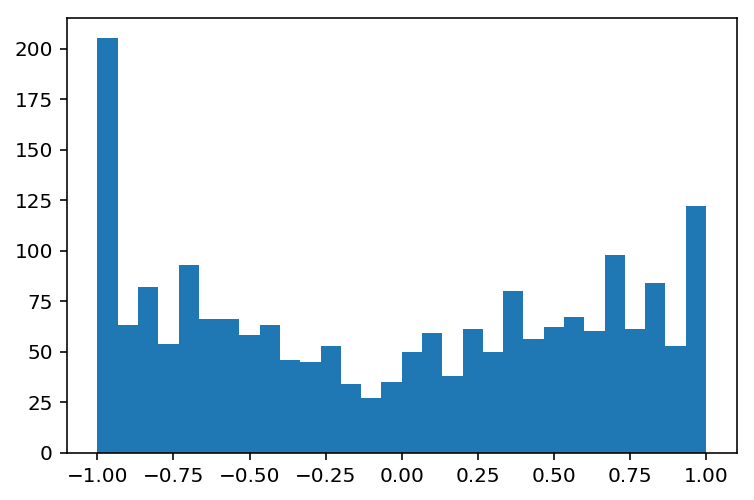

In [27]:
plt.hist(rho, bins=30)

In [28]:
pval, leng1 = zip(*[(x[1], y) for x, y in zip(corrs, [len(z) for z in outputs['sentence_attentions']]) if x[1] == x[1]])

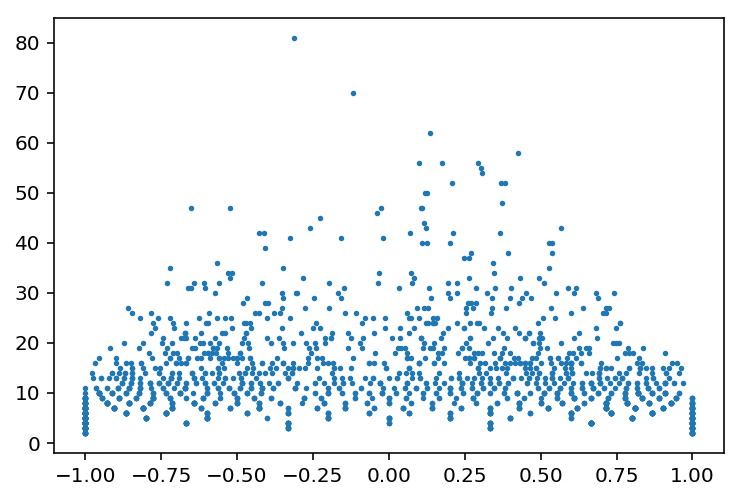

In [29]:
plt.scatter(rho, leng, s=3)